In [91]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import nnls
from trecs.validate import validate_user_item_inputs
from collections import defaultdict

N.B. This notebook is tested for the `main` branch of `t-recs` as of 1/27/2021.

# Generate synthetic data

First, we generate all the user / item data that will be used in each of our simulations (including the social network, which is used in the social filtering model). All parameters are from the Chaney et al. paper (see https://arxiv.org/pdf/1710.11214.pdf).

In [92]:
def gen_social_network(user_prefs):
    """ Generates a |U|x|U| social network of connections
        as specified in Chaney et al.
    """
    user_cov = np.cov(user_prefs)
    possible_thresholds = np.sort(user_cov.flatten())[::-1]
    user_connections = None
    for thresh in possible_thresholds[num_users:]:
        num_connected = (user_cov >= thresh).any(axis=1).sum()
        if num_connected == num_users:
            return (user_cov >= thresh).astype(int) # final adjacency matrix
    raise RuntimeError("Could not find a suitable threshold.")

    
def mu_sigma_to_alpha_beta(mu, sigma):
    """ For Chaney's custom Beta' function, we convert
        a mean and variance to an alpha and beta parameter
        of a Beta function. See footnote 3 page 3 of Chaney
        et al. for details.
    """
    alpha = ((1-mu) / (sigma**2) - (1/mu)) * mu**2
    beta = alpha * (1/mu - 1)
    return alpha, beta
    

# generate user vector
generator = np.random.default_rng()
# parameters from section 5 of paper
num_users = 100
num_items = 1000
num_attrs = 20
num_sims = 5

user_params = np.random.dirichlet(np.ones(num_attrs), size=num_sims) * 10
item_params = np.random.dirichlet(np.ones(num_attrs) * 100, size=num_sims) * 0.1
# do conversion from paper to fiure out the utility percentage visible to users
mu_n = 0.98  
sigma = 1e-5

# each element in users is the users vector in one simulation
users = []
items = []
true_utilities = []
known_util_perc = []
known_utils = []
social_networks = []
for sim_index in range(num_sims):
    # generate user preferences and item attributes
    user_prefs = np.random.dirichlet(user_params[sim_index, :], size=num_users) # 100 users
    item_attrs = np.random.dirichlet(item_params[sim_index, :], size=num_items) # 200 items
    
    # mean of the utility distribution
    true_utils_mu = user_prefs @ item_attrs.T
    true_utils_mu = np.clip(true_utils_mu, 1e-9, None) # avoid numerical stability issues
    # sample total utility from a beta distribution
    alphas, betas = mu_sigma_to_alpha_beta(true_utils_mu, sigma)
    true_utils = np.random.beta(alphas.flatten(), betas.flatten()).reshape((num_users, num_items))
    # assert support of true utilities; should be within 0 and 1
    assert true_utils.min() >= 0 and true_utils.max() <= 1
    
    # calculate known utility fo reach user
    alpha, beta = mu_sigma_to_alpha_beta(mu_n, sigma) # parameters for beta function governing percentage of utility known to users
    perc_known = np.random.beta(alpha, beta, size=(num_users, num_items))
    known_util = true_utils * perc_known 
    
    # add all synthetic data to list
    users.append(user_prefs) 
    social_networks.append(gen_social_network(user_prefs))
    items.append(item_attrs) 
    true_utilities.append(true_utils)
    known_util_perc.append(perc_known)
    known_utils.append(known_util)
    
    
# print shape
print(users[0].shape) # we should see 100 users with 20 attributes
print(items[0].shape) # we should see 1000 items with 20 attributes
print(true_utilities[0].shape)
print(known_utils[0].shape)

(100, 20)
(1000, 20)
(100, 1000)
(100, 1000)


Next, we visualize the true user utilities for each item  to verify that the resulting graph is similar to what appears in the Chaney paper.

Text(0.5, 1.0, 'True user-item utilities')

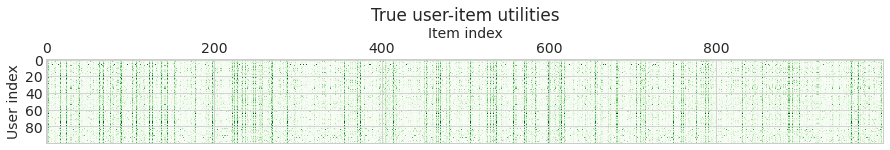

In [122]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utilities[0], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("True user-item utilities")
# this seems reasonably sparse and matches the picture in the Chaney paper! let's proceed

Text(0.5, 1.0, 'User-item utilities (known to user)')

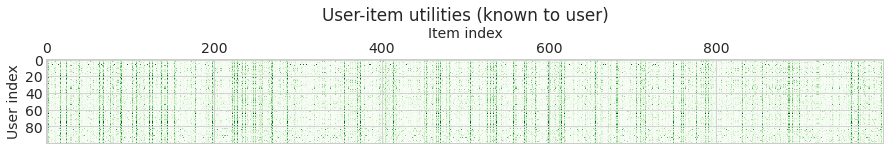

In [123]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utilities[0] * known_util_perc[0], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("User-item utilities (known to user)")

Text(0.5, 1.0, 'Item attributes')

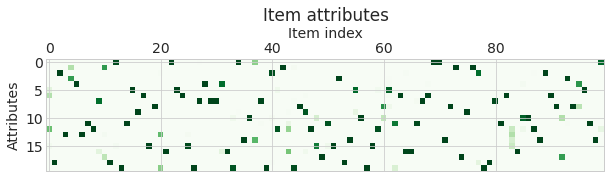

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow((items[0].T)[:, :100], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Attributes')
ax.set_title("Item attributes of first 100 item")

# Custom models/classes/metrics

Next, we create some custom models and metrics that will be used in our replication experiments. Most of the functionality is already in T-RECS, but we "customize" things here so we can measure the same things that Chaney measures. These include:
* Jaccard Similarity for pairs of similar users, where "similar" is defined by cosine similarity of model's internal user representation
* Ideal recommender system
* Random recommender system (randomly recommends items)
* Chaney content filtering system (updates internal representation of users by using `scipy.optimize.nnls` to solve for the least-squares approximation of user attributes)
* Custom content filtering system that "freezes" the model's internal representation of user attributes (important for the Jaccard Similarity metric mentioned earlier)

In [96]:
# try running simulation 
from trecs.models import ContentFiltering, PopularityRecommender, ImplicitMF, SocialFiltering
from trecs.components import Users, Items
from trecs.metrics import HomogeneityMeasurement, InteractionSimilarity, Measurement
from trecs.matrix_ops import normalize_matrix

In [97]:
from sklearn.metrics.pairwise import cosine_similarity

class SimilarUserInteractionSimilarity(Measurement):
    """
    Keeps track of the average Jaccard similarity between items seen by pairs
    of users at each timestep. The pairs of users must be passed in by the
    user.

    Parameters
    -----------
        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "similar_user_jaccard")
            Name of the measurement component.
    """

    def __init__(self, name="similar_user_jaccard", verbose=False):
        self.interaction_hist = None
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the average Jaccard index of items shown to pairs of users in
        the system, where each pair consists of a user and the user most similar
        to that user, according to the system's internal representation.
        Intuitively, a higher average Jaccard index corresponds to
        increasing "homogenization" in that the recommender system is starting
        to treat each user the same way (i.e., show them the same items).

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        
        interactions = kwargs.pop("interactions", None)
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractionSimilarity's `measure` "
                "method as a keyword argument"
            )

        if self.interaction_hist is None:
            self.interaction_hist = np.copy(interactions).reshape((-1, 1))
        else:
            self.interaction_hist = np.hstack([self.interaction_hist, interactions.reshape((-1, 1))])
        # generate cosine similarity matrix for all users
        sim_matrix = cosine_similarity(recommender.users_hat, recommender.users_hat)
        # set diagonal entries to zero
        num_users = sim_matrix.shape[0]
        sim_matrix[np.arange(num_users), np.arange(num_users)] = 0
        # array where element x at index i represents the "most similar" user to user i
        closest_users = np.argmax(sim_matrix, axis=1)
        
        # calculate average jaccard similarity
        similarity = 0
        for user1, user2 in enumerate(closest_users):
            itemset_1 = set(self.interaction_hist[user1, :])
            itemset_2 = set(self.interaction_hist[user2, :])
            common = len(itemset_1.intersection(itemset_2))
            union = len(itemset_1.union(itemset_2))
            similarity += common / union / num_users
        self.observe(similarity)

In [98]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
def perfect_score_fn(true_scores):
    def score_fn(*args):
        return true_scores
    return score_fn

In [99]:
# example usage of ideal recommender
true_prefs = users[0] # underlying true preferences
true_scores = true_utilities[0]
noisy_scores = known_utils[0]

u = Users(actual_user_scores = noisy_scores, size=(num_users, num_attrs), num_users=num_users) # each user interacts with items based on their (noisy) knowledge of their own scores
ideal_rec = IdealRecommender(item_representation=items[0].T, actual_user_representation=u, score_fn=perfect_score_fn(true_scores))
ideal_rec.startup_and_train(timesteps=10)
ideal_rec.run(
    timesteps=10,
    train_between_steps=False, 
    random_items_per_iter=ideal_rec.num_items_per_iter, 
    vary_random_items_per_iter=True
)

# run some sanity checks to ensure that nothing was altered during simulation
np.testing.assert_array_equal(u.actual_user_scores, noisy_scores)
# check that actual user scores as a percentage of the true utilities
# is the same as the known util percentages
np.testing.assert_array_equal(true_scores, ideal_rec.predicted_scores)

100%|██████████| 10/10 [00:00<00:00, 161.28it/s]


In [100]:
# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        self.users_hat[:, :] = np.random.randint(2, size=self.users_hat.shape)

In [101]:
# modify Content to fit chaney requirements
class CustomContent(ContentFiltering):
    """ We need this custom ContentFiltering class because in the single training case,
        the user representations should not be updated during training. Otherwise,
        it'll affect the calculation used for pairing similar users when we 
        measure SimilarUserInteractionSimilarity.
    """
    def __init__(self, *args, **kwargs):
        self.frozen = False
        super().__init__(*args, **kwargs)
        
    def freeze(self):
        self.frozen = True
    
    def _update_internal_state(self, interactions):
        if not self.frozen:
            super()._update_internal_state(interactions)

In [102]:
# Chaney ContentFiltering - uses NNLS solver
class ChaneyContent(ContentFiltering):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        
    def _update_internal_state(self, interactions):
        # update cumulative interactions
        self.cumulative_interactions[self.users.user_vector, interactions] += 1
        
    def train(self):
        if hasattr(self, 'cumulative_interactions') and self.cumulative_interactions.sum() > 0: # if there are interactions present:
            for i in range(self.num_users):
                self.users_hat[i, :] = nnls(self.items_hat.T, self.cumulative_interactions[i, :])[0] # solve for Content Filtering representation using nnls solver
        else:
            self.cumulative_interactions = np.zeros((self.users_hat.shape[0], self.items_hat.shape[1]))
        super().train()

In [103]:
# utility function to extract measurement
def process_measurement(model, metric_string):
    return model.get_measurements()[metric_string][1:]

In [104]:
# graphing
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})

# smoothing factor for visualizing curves
sigma = 1

# Repeated Training

Now, we actually run the recommender system models on the synthetic datasets. After each model finishes running, we extract two measures of homogenization (change in Jaccard index averaged over pairs of users that are randomly chosen, and the change in Jaccard index averaged over pairs of users that are most similar to each other by cosine similarity).

Note that this is the "repeated training" case, where algorithms are repeatedly updated with new data at each iteration. 

In [105]:
model_keys = ["ideal", "content_ours", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list)}

startup_iters = 10
sim_iters = 90
# simpler way to pass common arguments
run_params = {
    "train_between_steps": False,
    "random_items_per_iter": 3,
    "vary_random_items_per_iter": False,
    "timesteps": sim_iters,
    "repeated_items": False
}

for i in range(num_sims):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utilities[i]
    noisy_scores = known_utils[0]
    item_representation = items[i].T
    
    init_params = {
        "item_representation": item_representation,
        "actual_user_representation": 
    }

    # generate random pairs for evaluating jaccard similarity
    pairs = [np.random.choice(num_users, 2, replace=False) for _ in range(800)]

    # each user interacts with items based on their (noisy) knowledge of their own scores
    # user choices also depend on the order of items they are recommended
    u = Users(actual_user_scores = noisy_scores, size=(num_users, num_attrs), num_users=num_users, attention_exp=-0.8) 
    # recommender has the ideal item representation and ideal user representation
    ideal_rec = IdealRecommender(user_representation=true_prefs, item_representation=item_representation, actual_user_representation=u, score_fn=perfect_score_fn(true_scores))
    ideal_rec.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    ideal_rec.startup_and_train(timesteps=startup_iters)
    ideal_rec.run(**run_params)
    
    # chaney content filtering
    chaney = ChaneyContent(item_representation=item_representation, actual_user_representation=u)
    chaney.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    chaney.startup_and_train(timesteps=startup_iters)
    
    chaney.run(**run_params)
    
    # matrix factorization
    mf = ImplicitMF(actual_item_representation=item_representation, actual_user_representation=u)
    mf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    mf.startup_and_train(timesteps=startup_iters)
    
    mf.run(reset_interactions=False, **run_params)   
    # social filtering
    # translate covariance matrix into social network (enforces homophily)            
    sf = SocialFiltering(user_representation=social_networks[i], actual_item_representation=item_representation, actual_user_representation=u)
    sf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    sf.startup_and_train(timesteps=startup_iters)
    sf.run(**run_params)

    # popularity model
    p = PopularityRecommender(actual_item_representation=item_representation, actual_user_representation=u, num_items=num_items, num_users=num_users)
    p.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    p.startup_and_train(timesteps=startup_iters)
    p.run(**run_params)
    
    # random recommender
    r = RandomRecommender(item_representation=item_representation, actual_user_representation=u, num_items=num_items, num_users=num_users)
    r.add_metrics(InteractionSimilarity(pairs), InteractionSimilarity(pairs, name="similar_user_jaccard")) # random pairing of users
    r.startup_and_train(timesteps=startup_iters)
    r.run(**run_params)
    
    # extract results from each model
    rep_train_results["sim_users"]["ideal"].append(process_measurement(ideal_rec, "similar_user_jaccard"))
    rep_train_results["random_users"]["ideal"].append(process_measurement(ideal_rec, "interaction_similarity"))
    rep_train_results["sim_users"]["content_ours"].append(process_measurement(content, "similar_user_jaccard"))
    rep_train_results["random_users"]["content_ours"].append(process_measurement(content, "interaction_similarity"))
    rep_train_results["sim_users"]["content_chaney"].append(process_measurement(chaney, "similar_user_jaccard"))
    rep_train_results["random_users"]["content_chaney"].append(process_measurement(chaney, "interaction_similarity"))
    rep_train_results["sim_users"]["mf"].append(process_measurement(mf, "similar_user_jaccard"))
    rep_train_results["random_users"]["mf"].append(process_measurement(mf, "interaction_similarity"))
    rep_train_results["sim_users"]["sf"].append(process_measurement(sf, "similar_user_jaccard"))
    rep_train_results["random_users"]["sf"].append(process_measurement(sf, "interaction_similarity"))
    rep_train_results["sim_users"]["popularity"].append(process_measurement(p, "similar_user_jaccard"))
    rep_train_results["random_users"]["popularity"].append(process_measurement(p, "interaction_similarity"))
    rep_train_results["sim_users"]["random"].append(process_measurement(r, "similar_user_jaccard"))
    rep_train_results["random_users"]["random"].append(process_measurement(r, "interaction_similarity"))

100%|██████████| 90/90 [00:04<00:00, 21.06it/s]


## Change in Jaccard (users paired randomly)

In [106]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(rep_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

In [107]:
# readable legend keys
id_to_readable = {
    "ideal": "ideal", 
    "content_ours": "content (T-RECS)", 
    "content_chaney": "content (Chaney et al.)",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

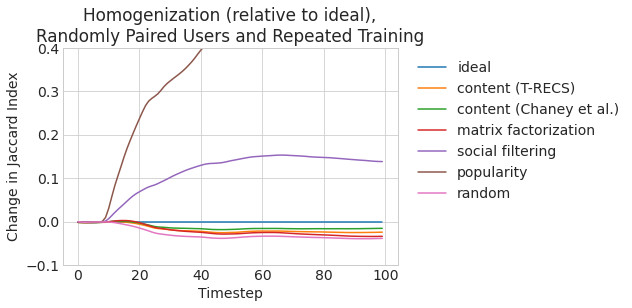

In [108]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.4)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Repeated Training")
plt.savefig('repeated_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [109]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(rep_train_results["sim_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["sim_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

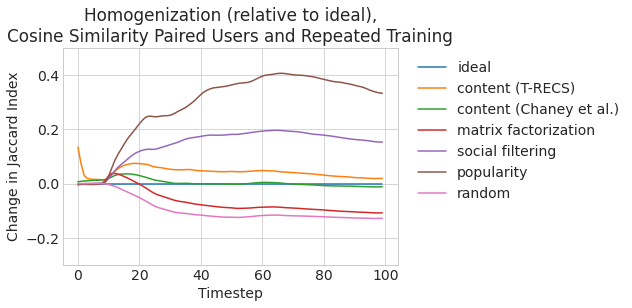

In [110]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.3, 0.5)
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
plt.savefig('repeated_training_sim_pair.pdf', bbox_inches = "tight")

# Single training

We do the same training with all of the same models just as we did earlier, but now we only train each model once - following the startup phase.

In [111]:
model_keys = ["ideal", "content_ours", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list)}

startup_iters = 50
sim_iters = 50
run_params = {
    "train_between_steps": False,
    "random_items_per_iter": 3,
    "vary_random_items_per_iter": False,
    "timesteps": sim_iters,
    "repeated_items": False
}

for i in range(num_sims):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utilities[i]
    noisy_scores = known_utils[0]
    item_representation = items[i].T

    # generate random pairs for evaluating jaccard similarity
    pairs = [np.random.choice(num_users, 2, replace=False) for _ in range(800)]

    # user choices also depend on the order of items they are recommended
    u = Users(actual_user_scores = noisy_scores, size=(num_users, num_attrs), num_users=num_users, attention_exp=-0.8) 
    # recommender has the ideal item representation and ideal user representation
    ideal_rec = IdealRecommender(user_representation=true_prefs, item_representation=item_representation, actual_user_representation=u, score_fn=perfect_score_fn(true_scores))
    ideal_rec.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    ideal_rec.startup_and_train(timesteps=startup_iters)
    ideal_rec.run(**run_params)
    
    # chaney content filtering
    chaney = ChaneyContent(item_representation=item_representation, actual_user_representation=u)
    chaney.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    chaney.startup_and_train(timesteps=startup_iters)
    
    chaney.run(**run_params)
    
    # matrix factorization
    mf = ImplicitMF(actual_item_representation=item_representation, actual_user_representation=u)
    mf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    mf.startup_and_train(timesteps=startup_iters)
    
    mf.run(reset_interactions=False, **run_params)
    
    # social filtering
    # translate covariance matrix into social network (enforces homophily)            
    sf = SocialFiltering(user_representation=social_networks[i], actual_item_representation=item_representation, actual_user_representation=u)
    sf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    sf.startup_and_train(timesteps=startup_iters)
    sf.run(**run_params)
    
    # popularity model
    p = PopularityRecommender(actual_item_representation=item_representation, actual_user_representation=u, num_items=num_items, num_users=num_users)
    p.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity())
    p.startup_and_train(timesteps=startup_iters)
    p.run(**run_params)
    
    # random recommender
    r = RandomRecommender(item_representation=item_representation, actual_user_representation=u, num_items=num_items, num_users=num_users)
    r.add_metrics(InteractionSimilarity(pairs), InteractionSimilarity(pairs, name="similar_user_jaccard"))
    r.startup_and_train(timesteps=startup_iters)
    r.run(
        timesteps=sim_iters,
        random_items_per_iter=random_items_per_iter, 
        vary_random_items_per_iter=vary_random_items_per_iter
    )
    
    # extract results from each model
    single_train_results["sim_users"]["ideal"].append(process_measurement(ideal_rec, "similar_user_jaccard"))
    single_train_results["random_users"]["ideal"].append(process_measurement(ideal_rec, "interaction_similarity"))
    single_train_results["sim_users"]["content_ours"].append(process_measurement(content, "similar_user_jaccard"))
    single_train_results["random_users"]["content_ours"].append(process_measurement(content, "interaction_similarity"))
    single_train_results["sim_users"]["content_chaney"].append(process_measurement(chaney, "similar_user_jaccard"))
    single_train_results["random_users"]["content_chaney"].append(process_measurement(chaney, "interaction_similarity"))
    single_train_results["sim_users"]["mf"].append(process_measurement(mf, "similar_user_jaccard"))
    single_train_results["random_users"]["mf"].append(process_measurement(mf, "interaction_similarity"))
    single_train_results["sim_users"]["sf"].append(process_measurement(sf, "similar_user_jaccard"))
    single_train_results["random_users"]["sf"].append(process_measurement(sf, "interaction_similarity"))
    single_train_results["sim_users"]["popularity"].append(process_measurement(p, "similar_user_jaccard"))
    single_train_results["random_users"]["popularity"].append(process_measurement(p, "interaction_similarity"))
    single_train_results["sim_users"]["random"].append(process_measurement(r, "similar_user_jaccard"))
    single_train_results["random_users"]["random"].append(process_measurement(r, "interaction_similarity"))

100%|██████████| 50/50 [00:05<00:00,  8.43it/s]


## Change in Jaccard (users paired randomly)

In [112]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(single_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

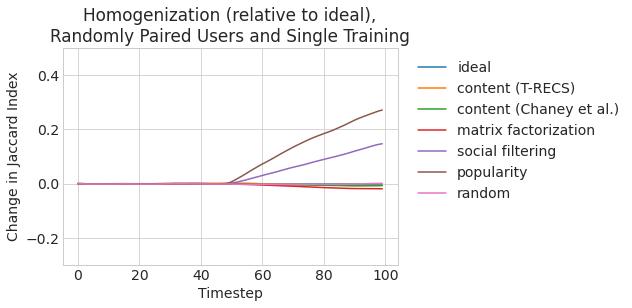

In [113]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.3, 0.5)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Single Training")
plt.savefig('single_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [114]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(single_train_results["sim_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["sim_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

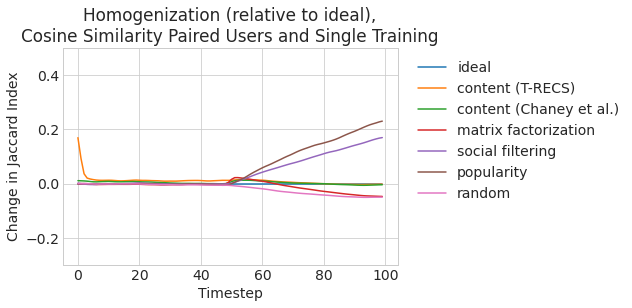

In [133]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.ylim(-0.3, 0.5)
plt.savefig('single_training_sim_pair.pdf', bbox_inches = "tight")

# Troubleshooting

In [78]:
# Test ideal recommender over time

# Visualize user profiles over time


In [114]:
num_users = 5
num_items = 10
num_attrs = 20

user_params = np.random.dirichlet(np.ones(num_attrs), size=1) * 10
item_params = np.random.dirichlet(np.ones(num_attrs) * 100, size=1) * 0.1
# do conversion from paper to fiure out the utility percentage visible to users
mu_n = 0.98  
sigma = 1e-5

print(f"mu_n: {mu_n}, sigma: {sigma}, alpha: {alpha}, beta: {beta}")
# each element in users is the users vector in one simulation
# generate user preferences and item attributes
user_prefs = np.random.dirichlet(user_params[0, :], size=num_users) 
item_attrs = np.random.dirichlet(item_params[0, :], size=num_items) 

# mean of the utility distribution
true_utils_mu = user_prefs @ item_attrs.T
true_utils_mu = np.clip(true_utils_mu, 1e-9, None) # avoid numerical stability issues
# sample total utility from a beta distribution
alphas, betas = mu_sigma_to_alpha_beta(true_utils_mu, sigma)
true_utils = np.random.beta(alphas.flatten(), betas.flatten()).reshape((num_users, num_items))
# assert support of true utilities; should be within 0 and 1
assert true_utils.min() >= 0 and true_utils.max() <= 1

# calculate known utility fo reach user
alpha, beta = mu_sigma_to_alpha_beta(mu_n, sigma) # parameters for beta function governing percentage of utility known to users
perc_known = np.random.beta(alpha, beta, size=(num_users, num_items))
known_util = true_utils * perc_known 

    
# print shape
print(user_prefs.shape) # we should see 100 users with 20 attributes
print(item_attrs.shape) # we should see 1000 items with 20 attributes
print(true_utils.shape)
print(known_util.shape)

mu_n: 0.98, sigma: 1e-05, alpha: 192079999.02000013, beta: 3919999.980000007
(5, 20)
(10, 20)
(5, 10)
(5, 10)


In [115]:
print(np.around(user_prefs, 3))

[[0.045 0.016 0.073 0.024 0.191 0.123 0.166 0.022 0.067 0.    0.105 0.
  0.001 0.099 0.047 0.011 0.    0.    0.001 0.01 ]
 [0.152 0.001 0.387 0.021 0.004 0.143 0.039 0.033 0.003 0.001 0.    0.006
  0.    0.141 0.009 0.001 0.    0.059 0.    0.   ]
 [0.    0.008 0.039 0.003 0.121 0.122 0.013 0.141 0.01  0.    0.    0.076
  0.    0.077 0.034 0.001 0.    0.355 0.    0.   ]
 [0.004 0.011 0.104 0.018 0.107 0.184 0.111 0.088 0.032 0.    0.    0.
  0.004 0.18  0.    0.132 0.    0.005 0.02  0.   ]
 [0.133 0.001 0.194 0.    0.009 0.086 0.049 0.047 0.023 0.    0.002 0.
  0.013 0.073 0.048 0.094 0.    0.229 0.    0.   ]]


In [118]:
highest_util_items = true_utils.argmax(axis=1)
highest_known_util = known_util.argmax(axis=1)
sorted_by_known_util = known_util.argsort(axis=1)
for i in range(num_users):
    print(f"User {i} highest total utility item is {highest_util_items[i]}")
    print(f"User {i}'s true utility for all items is:")
    print(np.around(true_utils[i, :], decimals=3))
    print(f"User {i} highest known utility item is {highest_known_util[i]}")
    print(f"User {i}'s known utility for all items is:")
    print(np.around(known_util[i, :], decimals=3))
    print(f"User {i} prefers items in this order: {sorted_by_known_util[i, :][::-1]}")
    print()

User 0 highest total utility item is 7
User 0's true utility for all items is:
[0.    0.011 0.    0.074 0.001 0.    0.022 0.166 0.047 0.02 ]
User 0 highest known utility item is 7
User 0's known utility for all items is:
[0.    0.01  0.    0.072 0.001 0.    0.022 0.163 0.046 0.02 ]
User 0 prefers items in this order: [7 3 8 6 9 1 4 2 5 0]

User 1 highest total utility item is 3
User 1's true utility for all items is:
[0.    0.001 0.006 0.105 0.    0.    0.033 0.039 0.009 0.002]
User 1 highest known utility item is 3
User 1's known utility for all items is:
[0.    0.001 0.005 0.103 0.    0.    0.032 0.039 0.009 0.002]
User 1 prefers items in this order: [3 7 6 8 2 9 1 0 5 4]

User 2 highest total utility item is 6
User 2's true utility for all items is:
[0.    0.001 0.076 0.058 0.    0.    0.141 0.013 0.034 0.008]
User 2 highest known utility item is 6
User 2's known utility for all items is:
[0.    0.001 0.074 0.056 0.    0.    0.138 0.013 0.033 0.008]
User 2 prefers items in this orde

In [119]:
# try without random items

u = Users(actual_user_scores = known_util, size=(num_users, num_attrs), num_users=num_users, attention_exp=-0.8, verbose=True) 
ideal_rec = IdealRecommender(item_representation=item_attrs.T, actual_user_representation=u, score_fn=perfect_score_fn(true_utils), verbose=True, num_items_per_iter=3)
ideal_rec.startup_and_train(timesteps=1)
ideal_rec.run(
    timesteps=5,
    train_between_steps=False, 
    random_items_per_iter=0, 
    vary_random_items_per_iter=False,
    
)

100%|██████████| 5/5 [00:00<00:00, 53.21it/s]


In [120]:
# try with random items 

u = Users(actual_user_scores = known_util, size=(num_users, num_attrs), num_users=num_users, attention_exp=-0.8, verbose=True) 
ideal_rec = IdealRecommender(item_representation=item_attrs.T, actual_user_representation=u, score_fn=perfect_score_fn(true_utils), verbose=True, num_items_per_iter=3)
ideal_rec.startup_and_train(timesteps=1)
ideal_rec.run(
    timesteps=5,
    train_between_steps=False, 
    random_items_per_iter=1, 
    vary_random_items_per_iter=False,
    
)

100%|██████████| 5/5 [00:00<00:00, 47.79it/s]
